In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path

['/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/home/jon/projects/embeddedml/handson/openml-18/venv/lib/python3.11/site-packages']

In [12]:

import seaborn
import pandas
from matplotlib import pyplot as plt


from analyze import enrich_results, plot_size_improvement, name_strategies



In [13]:
data = pandas.read_parquet('out.parquet')
data = enrich_results(data)
data.head(5)

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,run,leaf_size,decision_size,total_size
id,,,,,,,,,,,,,,
729ae506-08c5-4c0f-8879-abd9a97c3499,NaN,NaN,0,482,246,2.0,111,89.333767,1049,rf10_none,DCD30F_rf10_none,888.0,472,1360.0
ba1b1b7f-2623-4e57-9fdd-6990c5d124f1,1.0,NaN,0,482,246,2.0,2,88.595920,1049,rf10_none,DCD30F_rf10_none,16.0,472,488.0
8d1c0bfd-44a1-472c-b77f-1ac3a84c2ff9,2.0,NaN,0,482,246,2.0,4,89.040799,1049,rf10_none,DCD30F_rf10_none,32.0,472,504.0
72ab187a-232f-46eb-afdf-d45aeabaa86e,4.0,NaN,0,482,246,2.0,8,89.328342,1049,rf10_none,DCD30F_rf10_none,64.0,472,536.0
2de8bb7a-75ab-45f6-8d8f-ca11a2c50899,8.0,NaN,0,482,246,2.0,16,89.290365,1049,rf10_none,DCD30F_rf10_none,128.0,472,600.0


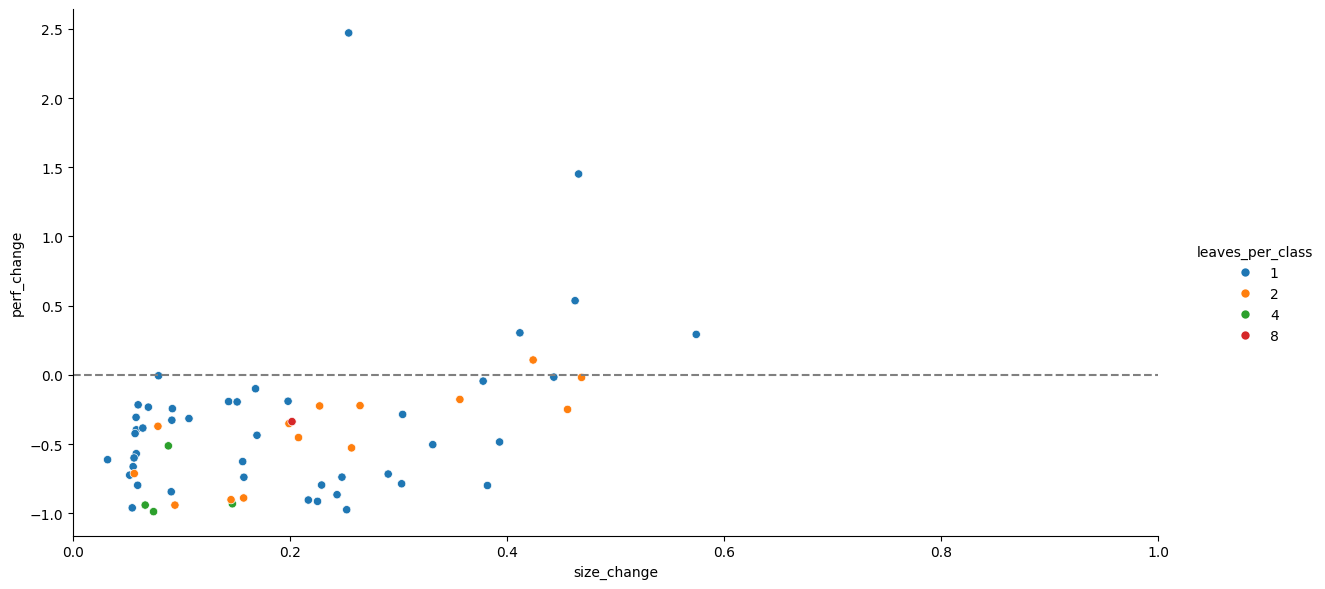

In [14]:
plot_size_improvement(data, path=None)

In [15]:
pandas.__version__

'2.2.2'

strategy
majority    1575
Name: count, dtype: int64
Wrote majority-perf.png


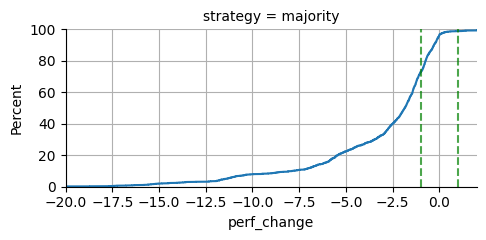

In [49]:
def plot_majority_error(df, path=None):

    # Filter data
    pass

    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        matches = df[df.leaves_per_class.isna() & df.leaf_bits.isna()]
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        matches = df[df.leaves_per_class.isna() & df.leaf_bits.isna()]
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] / ref
        return out

    grouped = df.groupby(['dataset', 'split'], as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')['test_roc_auc']
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']

    df = name_strategies(df)

    df = df[df.strategy.isin(['majority',
                              #'quantize'
                             ])]
    #df 
    df = df[(df.strategy == 'majority') | (df.leaf_bits == 8)]

    print(df.strategy.value_counts())
    
    #df.groupby(['dataset', ''])

    # make categorical
    df['leaves_per_class'] = df['leaves_per_class'].astype('Int64').astype(str)

    # Plot results
    g = seaborn.displot(data=df, kind='ecdf',
        x='perf_change', row='strategy',
        #common_norm=True,
        stat='percent',
        height=2.5, aspect=2.0, #s=5.0,
    )
    g.refline(x=-1.0, color='green', alpha=0.7)
    g.refline(x=+1.0, color='green', alpha=0.7)
    #g.refline(x=+0.1)
    g.set(ylim=(0, 100), xlim=(-20, +2))

    for ax in g.axes.flatten():
        ax.grid()  
    
    if path is not None:
        g.figure.savefig(path)
        print('Wrote', path)

    return g

plot_majority_error(data, path='majority-perf.png')

strategy
leaf_per_class > 4    4725
majority              1575
leaf_per_class = 1    1575
leaf_per_class = 2    1575
leaf_per_class = 4    1575
Name: count, dtype: int64
Wrote perf-custering-vs-majority.png


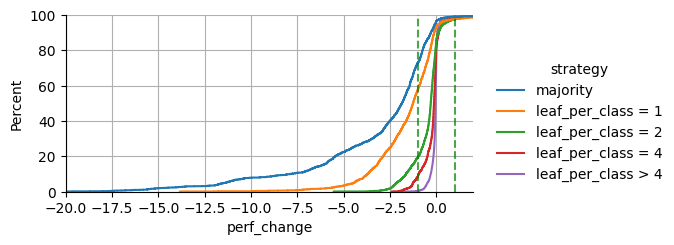

In [58]:
def plot_majority_error(df, path=None):

    # Filter data
    pass

    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        matches = df[df.leaves_per_class.isna() & df.leaf_bits.isna()]
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        matches = df[df.leaves_per_class.isna() & df.leaf_bits.isna()]
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] / ref
        return out

    grouped = df.groupby(['dataset', 'split'], as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')['test_roc_auc']
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']

    df = name_strategies(df)

    df = df[df.strategy.isin(['majority',
                              'joint'
                             ])]
    #df 
    #df = df[(df.strategy == 'majority') | ((df.leaf_bits == 8) & (df.leaves_per_class < 2))]

    df = df[(df.strategy == 'majority') | (df.leaf_bits == 8)]

    #df = df[]
    df.loc[(df.strategy == 'joint') & (df.leaves_per_class == 1), 'strategy'] = 'leaf_per_class = 1'
    df.loc[(df.strategy == 'joint') & (df.leaves_per_class == 2), 'strategy'] = 'leaf_per_class = 2'
    df.loc[(df.strategy == 'joint') & (df.leaves_per_class == 4), 'strategy'] = 'leaf_per_class = 4'
    df.loc[(df.strategy == 'joint') & (df.leaves_per_class > 4), 'strategy'] = 'leaf_per_class > 4'

    print(df.strategy.value_counts())
    
    #df.groupby(['dataset', ''])

    # make categorical
    df['leaves_per_class'] = df['leaves_per_class'].astype('Int64').astype(str)

    # Plot results
    g = seaborn.displot(data=df, kind='ecdf',
        x='perf_change', hue='strategy',
        #common_norm=True,
        stat='percent',
        height=2.5, aspect=2.0, #s=5.0,
    )
    g.refline(x=-1.0, color='green', alpha=0.7)
    g.refline(x=+1.0, color='green', alpha=0.7)
    #g.refline(x=+0.1)
    g.set(ylim=(0, 100), xlim=(-20, +2))

    for ax in g.axes.flatten():
        ax.grid()  
    
    if path is not None:
        g.figure.savefig(path)
        print('Wrote', path)

    return g

plot_majority_error(data, path='perf-custering-vs-majority.png')

leaves_per_class
0.0    1575
1.0    1575
2.0    1575
4.0    1575
8.0    1575
Name: count, dtype: int64
Wrote tradeoff-clustering-vs-majority.png


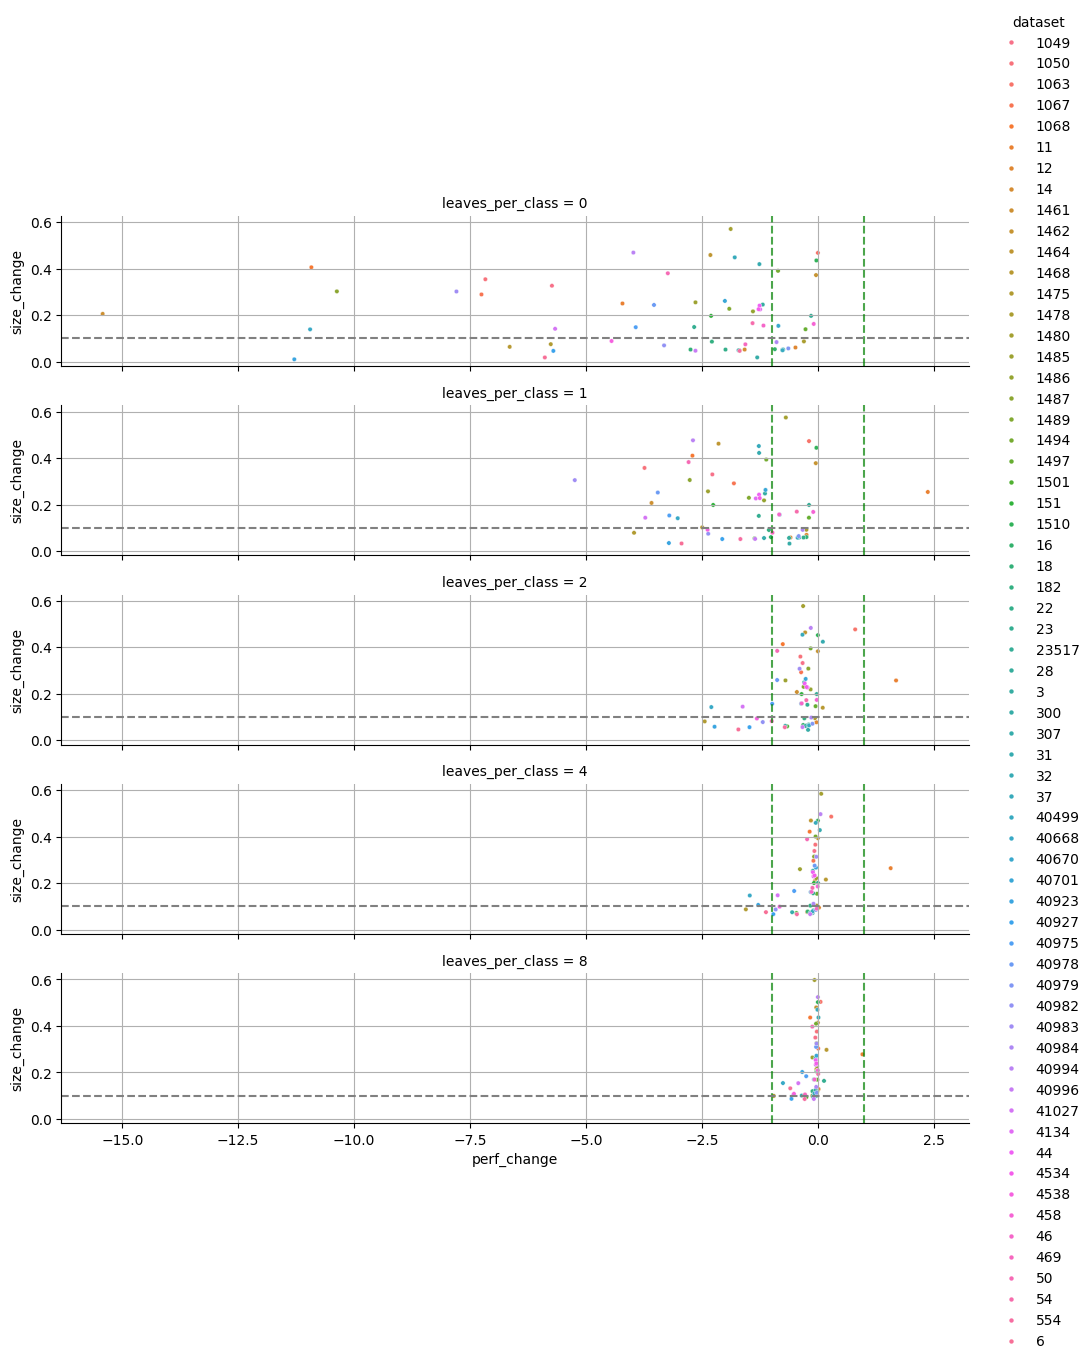

In [92]:


def plot_tradeoff(df, path=None):

    # Filter data
    pass

    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        matches = df[df.leaves_per_class.isna() & df.leaf_bits.isna()]
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        matches = df[df.leaves_per_class.isna() & df.leaf_bits.isna()]
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] / ref
        return out

    grouped = df.groupby(['dataset', 'split'], as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')['test_roc_auc']
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']

    df = name_strategies(df)

    df = df[df.strategy.isin(['majority',
                              'joint'
                             ])]
    df = df[(df.strategy == 'majority') | (df.leaf_bits == 8)]

    # use 0 to represent hard majority
    df['leaves_per_class'] = df['leaves_per_class'].fillna(0)
    df = df[df.leaves_per_class <= 8] # more is not needed
    
    #df = df[]
    df.loc[(df.strategy == 'joint') & (df.leaves_per_class == 1), 'strategy'] = 'leaf_per_class = 1'
    df.loc[(df.strategy == 'joint') & (df.leaves_per_class == 2), 'strategy'] = 'leaf_per_class = 2'
    df.loc[(df.strategy == 'joint') & (df.leaves_per_class == 4), 'strategy'] = 'leaf_per_class = 4'
    df.loc[(df.strategy == 'joint') & (df.leaves_per_class > 4), 'strategy'] = 'leaf_per_class > 4'

    #print(df.strategy.value_counts())
    print(df.leaves_per_class.value_counts(dropna=True))

    # make numerical
    df['leaves_per_class'] = df['leaves_per_class'].astype('Int64')
    # make categorical. Avoid the NaN = hard majority missing
    #df['leaves_per_class_cat'] = df['leaves_per_class'].astype('Int64').astype(str)

    #df['size_change'] = 1.0 / df['size_change']
    bb = df.groupby(['dataset', 'leaves_per_class'], dropna=False).median(numeric_only=True)

    # Plot results
    g = seaborn.relplot(data=bb, kind='scatter',
        x='perf_change', y='size_change', row='leaves_per_class', hue='dataset',
        height=2.0, aspect=5.0, s=10.0,
    )
    g.refline(x=-1.0, color='green', alpha=0.7)
    g.refline(x=+1.0, color='green', alpha=0.7)
    g.refline(y=+0.10)
    #g.set(ylim=(0, 100), xlim=(-20, +2))

    for ax in g.axes.flatten():
        ax.grid()  
    
    if path is not None:
        g.figure.savefig(path)
        print('Wrote', path)

    return g

plot_tradeoff(data, path='tradeoff-clustering-vs-majority.png')


leaf_bits
8.0    9450
0.0    1575
Name: count, dtype: int64
strategy
joint       378
majority     63
Name: count, dtype: int64
leaves_per_class
1.0     63
2.0     63
4.0     63
8.0     63
16.0    63
32.0    63
NaN     63
Name: count, dtype: int64


/tmp/ipykernel_136338/1458767112.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best = best.groupby(['dataset', 'strategy'], as_index=False).apply(find_best)


Wrote size-while-within-perf.png


<Axes: xlabel='dataset', ylabel='size_percent'>

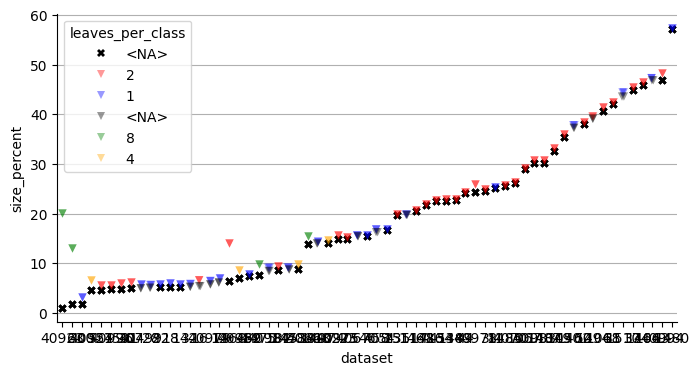

In [176]:

def plot_size_improvement2(df, path):

    # Filter data
    pass

    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        matches = df[df.leaves_per_class.isna() & df.leaf_bits.isna()]
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        matches = df[df.leaves_per_class.isna() & df.leaf_bits.isna()]
        assert len(matches) == 1, matches
        ref = matches.iloc[0][metric]
        out = df[metric] / ref
        return out

    grouped = df.groupby(['dataset', 'split'], as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')['test_roc_auc']
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']

    df = name_strategies(df)

    df = df[df.strategy.isin(['joint', 'majority'])]
    df = df[(df.strategy == 'majority') | (df.leaf_bits == 8)]

    print(df.leaf_bits.value_counts(dropna=False))
    
    best = df.groupby(['dataset', 'leaves_per_class'], dropna=False).median(numeric_only=True).reset_index()
    best['perf_ok'] = False
    best.loc[best.perf_change >= -1.0, 'perf_ok'] = True
    best = name_strategies(best)

    print(best.strategy.value_counts())
    
    print(best.leaves_per_class.value_counts(dropna=False))
    
    def find_best(df):
        s = df.sort_values('size_change', ascending=True)
        above = s[s.perf_change >= -1.0]
        if len(above):
            return above.iloc[0]
        else:
            return s.iloc[0]

    best = best.groupby(['dataset', 'strategy'], as_index=False).apply(find_best)

    # make categorical
    best['leaves_per_class'] = best['leaves_per_class'].astype('Int64').astype(str)
    
    #print(best.strategy.value_counts())
    
    # Plot results
    fig, ax = plt.subplots(1, figsize=(8, 4))
    #best = best.reset_index()
    order = best.sort_values('size_change')['dataset']

    best['size_percent'] = best['size_change'] * 100.0
    
    palette = {
        '<NA>': 'black',
        '1': 'blue',
        '2': 'red',
        '4': 'orange',
        '8': 'green',
    }
    for perf_status in [False, True]:
        marker = 'v' if perf_status else 'X'
        #palette = "flare" if perf_status else 'grey'
        alpha = 0.40 if perf_status else 1.0
        sub = best[best['perf_ok'] == perf_status]

        # TODO: add lollipop type lines between the two groups
        # https://python-graph-gallery.com/184-lollipop-plot-with-2-groups/
        # FIXME: do not have opacity for the majority marker when round
        seaborn.stripplot(ax=ax, data=sub, marker=marker,
            x='dataset', y='size_percent',
            hue='leaves_per_class',
            palette=palette,
            order=order,
            alpha=alpha,
            s=6.0,
            #dodge=True,
            #height=6, aspect=2.0, ,
        )
    #ax.axhline(y=10, ls='--', color='black', alpha=0.5)
    ax.grid(which='major', axis='y')
    seaborn.despine(ax=ax)
    #g.refline(y=0.0)
    #g.set(xlim=(0, 1.0))

    if path is not None:
        ax.figure.savefig(path)
        print('Wrote', path)

    return ax

plot_size_improvement2(data, path='size-while-within-perf.png')